In [10]:
# Import packages for data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them.
import pickle

### Data Conection to S3

In [11]:
#Import packages for data connection to S3
import boto3
from io import StringIO

In [12]:
# Path to local CSV file
file_path = r'C:\Users\carlo\Downloads\bucketcredentials.csv'
credentials_df = pd.read_csv(file_path)

aws_access_key_id = credentials_df['aws_access_key_id'].iloc[0]
aws_secret_access_key = credentials_df['aws_secret_access_key'].iloc[0]
bucket_name = credentials_df['bucket_name'].iloc[0]

input_file_key = 'SourceDataSet/bank_data_train.csv'
output_file_key = 'TargetDataSet/clean_bankchurn.csv'

In [13]:
# Create an S3 client
s3_client = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

In [14]:

# Read the CSV file from S3 into a DataFrame
obj = s3_client.get_object(Bucket=bucket_name, Key=input_file_key)
df = pd.read_csv(obj['Body'])

In [15]:
# Read in the data
#df = pd.read_csv('bank_data_train.csv')

In [16]:
df.head()

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,PRC_ACCEPTS_A_AMOBILE,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,PRC_ACCEPTS_TK,PRC_ACCEPTS_A_MTP,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,CNT_ACCEPTS_TK,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,PRC_ACCEPTS_A_ATM,PRC_ACCEPTS_MTP,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CNT_ACCEPTS_MTP,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146841,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.541683,0,156067.339800,NaN,NaN,NaN,0.0,начальник отдела,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,0,NaN,NaN,0.0,1.000000,1.000000,0.0,660,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.134651,0.0,NaN,NaN,NaN,0.0,0.474134,NaN,0.131910,0.0,NaN,0.0,0.406780,0.101695,0.0,0.483032,NaN,NaN,NaN,NaN,NaN,0.134634,0.0,NaN,NaN,0.442285,K01,NaN,NaN,1.593023,NaN,0.0,NaN,0.0,NaN,0.483032,NaN,0.406780,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
1,146842,0,0.041033,NaN,NaN,NaN,NaN,0.0,0.166667,0.186107,0.244678,NaN,0.670968,NaN,NaN,NaN,0.0,0.666667,NaN,NaN,0.000000,0,4278.845817,NaN,NaN,NaN,0.0,NaN,NaN,0.454545,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,0,NaN,NaN,0.0,0.109091,0.410691,0.0,552,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.239365,0.0,NaN,NaN,NaN,0.0,0.384264,0.6,0.101934,0.0,0.510712,0.0,0.333333,0.166667,0.0,0.200000,NaN,NaN,NaN,0.309799,NaN,0.133333,0.0,0.24,NaN,0.515876,102,NaN,NaN,1.587647,NaN,0.0,NaN,0.0,NaN,0.394340,NaN,0.545455,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
2,146843,0,0.006915,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.000000,0,112837.062800,NaN,NaN,NaN,0.0,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР,NaN,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0,NaN,0,NaN,NaN,0.0,0.810811,0.925140,0.0,420,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.084341,0.0,NaN,NaN,NaN,0.0,0.336136,NaN,0.121041,0.0,NaN,0.0,0.366667,0.133333,0.0,0.431656,NaN,NaN,NaN,NaN,NaN,0.063129,0.0,NaN,NaN,0.522833,102,NaN,NaN,1.587647,NaN,0.0,NaN,0.0,NaN,0.399342,NaN,0.297297,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
3,146844,0,0.00

## Data cleaning and pre-processing

### 1. Changing to lowercase column names to improve readability.

In [17]:
# Loop through each column name
for col in df.columns:
  # Check if the column name is uppercase
  if col.isupper():
    # Rename the column to lowercase
    df.rename(columns={col: col.lower()}, inplace=True)

df.columns

Index(['id', 'cr_prod_cnt_il', 'amount_rub_clo_prc',
       'prc_accepts_a_email_link', 'app_registr_rgn_code', 'prc_accepts_a_pos',
       'prc_accepts_a_tk', 'turnover_dynamic_il_1m', 'cnt_tran_aut_tendency1m',
       'sum_tran_aut_tendency1m',
       ...
       'rest_dynamic_cc_3m', 'med_debt_prc_ywz', 'ldeal_act_days_pct_tr3',
       'ldeal_act_days_pct_aavg', 'ldeal_delinq_per_maxywz',
       'turnover_dynamic_cc_3m', 'ldeal_act_days_pct_tr',
       'ldeal_act_days_pct_tr4', 'ldeal_act_days_pct_curr', 'target'],
      dtype='object', length=116)

>Using describe function to understand better the data

In [18]:
df.describe(include='all')

,id,cr_prod_cnt_il,amount_rub_clo_prc,prc_accepts_a_email_link,app_registr_rgn_code,prc_accepts_a_pos,prc_accepts_a_tk,turnover_dynamic_il_1m,cnt_tran_aut_tendency1m,sum_tran_aut_tendency1m,amount_rub_sup_prc,prc_accepts_a_amobile,sum_tran_aut_tendency3m,clnt_trust_relation,prc_accepts_tk,prc_accepts_a_mtp,rest_dynamic_fdep_1m,cnt_tran_aut_tendency3m,cnt_accepts_tk,app_marital_status,rest_dynamic_save_3m,cr_prod_cnt_vcu,rest_avg_cur,cnt_tran_med_tendency1m,app_kind_of_prop_habitation,clnt_job_position_type,amount_rub_nas_prc,clnt_job_position,app_driving_license,trans_count_sup_prc,app_education,cnt_tran_clo_tendency1m,sum_tran_med_tendency1m,prc_accepts_a_atm,prc_accepts_mtp,trans_count_nas_prc,app_travel_pass,cnt_accepts_mtp,cr_prod_cnt_tovr,app_car,cr_prod_cnt_pil,sum_tran_clo_tendency1m,app_position_type,turnover_cc,trans_count_atm_prc,amount_rub_atm_prc,turnover_paym,age,cnt_tran_med_tendency3m,cr_prod_cnt_cc,sum_tran_med_tendency3m,rest_dynamic_fdep_3m,rest_dynamic_il_1m,app_emp_type,sum_tran_clo_tendency3m,ldeal_tenor_max,ldeal_yqz_chrg,cr_prod_cnt_ccfp,deal_yqz_ir_max,ldeal_yqz_com,deal_yqz_ir_min,cnt_tran_clo_tendency3m,rest_dynamic_cur_1m,rest_avg_paym,ldeal_tenor_min,ldeal_amt_month,app_comp_type,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,cnt_tran_sup_tendency3m,turnover_dynamic_cur_1m,rest_dynamic_paym_3m,sum_tran_sup_tendency3m,rest_dynamic_il_3m,cnt_tran_atm_tendency3m,cnt_tran_atm_tendency1m,turnover_dynamic_il_3m,sum_tran_atm_tendency3m,deal_grace_days_acc_s1x1,avg_pct_month_to_pclose,deal_ywz_ir_min,sum_tran_sup_tendency1m,deal_ywz_ir_max,sum_tran_atm_tendency1m,rest_dynamic_paym_1m,cnt_tran_sup_tendency1m,deal_grace_days_acc_avg,turnover_dynamic_cur_3m,pack,max_pclose_date,ldeal_yqz_pc,clnt_setup_tenor,deal_grace_days_acc_max,turnover_dynamic_paym_3m,ldeal_delinq_per_maxyqz,turnover_dynamic_paym_1m,clnt_salary_value,trans_amount_tendency3m,med_debt_prc_yqz,trans_cnt_tendency3m,ldeal_used_amt_avg_yqz,rest_dynamic_cc_1m,ldeal_used_amt_avg_ywz,turnover_dynamic_cc_1m,avg_pct_debt_to_deal_amt,ldeal_act_days_acc_pct_avg,rest_dynamic_cc_3m,med_debt_prc_ywz,ldeal_act_days_pct_tr3,ldeal_act_days_pct_aavg,ldeal_delinq_per_maxywz,turnover_dynamic_cc_3m,ldeal_act_days_pct_tr,ldeal_act_days_pct_tr4,ldeal_act_days_pct_curr,target
count,355190.000000,355190.000000,316867.000000,155163.0,60550.000000,155163.0,155163.0,355190.000000,77112.000000,77112.000000,316867.000000,155163.0,111052.000000,69421,155163.0,155163.0,355190.000000,111052.000000,155163.0,68234,355190.000000,355190.000000,3.551900e+05,68967.000000,59361,44781,316867.000000,210811,57257,316867.000000,68104,66296.000000,68967.000000,155163.0,155163.0,316867.000000,57257,155163.0,355190.000000,57256,355190.000000,6.629600e+04,60545,3.551900e+05,316867.000000,316867.000000,3.551900e+05,355190.000000,115877.000000,355190.000000,115877.000000,355190.000000,355190.000000,67362,114898.000000,8001.000000,1.241000e+03,355190.000000,8001.000000,1.240000e+03,8001.000000,114898.000000,355190.000000,3.551900e+05,8001.000000,1.888000e+03,67362,355190.000000,355190.000000,198718.000000,355190.000000,355190.000000,198718.000000,355190.000000,255595.000000,205874.000000,355190.000000,255595.000000,70449.000000,1628.000000,95713.000000,155995.000000,95713.000000,205874.000000,355190.000000,155995.000000,69433.000000,355190.000000,355190,1881.000000,2.808000e+03,355190.000000,69433.000000,355190.000000,8001.000000,355190.000000,712.000000,303194.000000,8001.000000,303194.000000,8001.000000,355190.000000,95713.000000,355190.000000,1888.000000,93448.000000,355190.000000,95713.000000,93448.000000,98175.000000,95713.000000,355190.000000,93448.000000,93448.000000,93448.000000,355190.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN,5,4,NaN,19552,2,NaN,17,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Notice that the prc_accepts_a_tk have values nan and 0.  

In [19]:
df['prc_accepts_a_tk'].unique()

array([nan,  0.])

>Now, let's create a quick function to get the column names of those with values as "nan" and "0."

In [20]:
# Identify the columns with only nan and zero values

def get_zero_and_nan_columns(df):
    zero_and_nan_columns = []
    for col in df.columns:
        if df[col].nunique() == 1:
            zero_and_nan_columns.append(col)
    return zero_and_nan_columns

zero_and_nan_columns = get_zero_and_nan_columns(df)
zero_and_nan_columns

['prc_accepts_a_email_link',
 'prc_accepts_a_pos',
 'prc_accepts_a_tk',
 'prc_accepts_a_amobile',
 'prc_accepts_tk',
 'prc_accepts_a_mtp',
 'cnt_accepts_tk',
 'prc_accepts_a_atm',
 'prc_accepts_mtp',
 'cnt_accepts_mtp']

>Having 10 columns containing only "nan" and "0." can negatively impact our machine learning model. These values offer no meaningful distinction between data points, making it difficult for the model to learn patterns and relationships within your data. This can lead to poor model performance and inaccurate predictions. 

### 2. Dropping columns with this "nan" and "0." values.

In [21]:
# Dropping columns zero_and_nan_columns 
df = df.drop(columns=zero_and_nan_columns)
df.shape

(355190, 106)

>We also find two columns with values in Rusian language. Machine learning models typically struggle with non-numeric data, especially different languages.  Translating the values to English creates a common language the model can understand. 

In [22]:
df['clnt_trust_relation'].unique()

array([nan, 'MOTHER', 'BROTHER', 'FRIEND', 'SISTER', 'OTHER', 'RELATIVE',
       'DAUGHTER', 'SON', 'FATHER', 'Близкий ро', 'Друг', 'Отец',
       'Сестра', 'Сын', 'Мать', 'Муж', 'Брат', 'мать', 'Дальний ро',
       'Дочь', 'Жена'], dtype=object)

In [23]:
df['clnt_job_position'].unique()

array(['начальник отдела', nan, 'ГЕНЕРАЛЬНЫЙ ДИРЕКТОР', ...,
       'Эксперт контакт Центра', 'ПРОХЛДЧИК',
       'ХУДОЖНИК КОМПЬЮТЕРНОЙ ГРАФИКИ'], dtype=object)

### 3. Translating Rusian Values

After creating a dictionary with the rusian values we applied a function to translate those values:

In [24]:
def replace_russian_values(df, columns_to_translate, russian_to_english_dict):
  
  # Create a copy to avoid modifying the original DataFrame
  replaced_df = df.copy()

  # Replace values in specified columns
  for col in columns_to_translate:
    replaced_df[col] = replaced_df[col].replace(russian_to_english_dict)

  return replaced_df

# Russian to English dictionary (replace with your actual dictionary)
russian_to_english_dict = {
    "MOTHER": "mother",
    "BROTHER": "brother",
    "FRIEND": "friend",
    "SISTER": "sister",
    "OTHER": "other",
    "RELATIVE": "relative",
    "DAUGHTER": "daughter",
    "SON": "son",
    "FATHER": "father",
    "Близкий ро": "close ro",
    "Друг": "friend",
    "Отец": "father",
    "Сестра": "sister",
    "Сын": "son",
    "Мать": "mother",
    "Муж": "husband",
    "Брат": "brother",
    "мать": "mother",
    "Дальний ро": "far ro",
    "Дочь": "daughter",
    "Жена": "wife",
    "начальник отдела": "department head",
    "ГЕНЕРАЛЬНЫЙ ДИРЕКТОР": "ceo",
    "Эксперт контакт Центра": "expert contact center",
    "ПРОХЛДЧИК": "cool",
    "ХУДОЖНИК КОМПЬЮТЕРНОЙ ГРАФИКИ": "computer graphics artist",
    
}

# Columns to replace (replace with your actual column names)
columns_to_translate = ['clnt_trust_relation', 'clnt_job_position']

# Replace the specified columns
df = replace_russian_values(df, columns_to_translate, russian_to_english_dict)


>Checking the unique values in the translated columns:

In [25]:
df['clnt_trust_relation'].unique()

array([nan, 'mother', 'brother', 'friend', 'sister', 'other', 'relative',
       'daughter', 'son', 'father', 'close ro', 'husband', 'far ro',
       'wife'], dtype=object)

In [26]:
df['clnt_job_position'].unique()

array(['department head', nan, 'ceo', ..., 'expert contact center',
       'cool', 'computer graphics artist'], dtype=object)

### 4. Managing null values

In [27]:
# Counting null values

def count_nulls(df):
    for column in df.columns:
        print(f'Nulls in column {column}:', df[column].isnull().sum())
        
count_nulls(df)

Nulls in column id: 0
Nulls in column cr_prod_cnt_il: 0
Nulls in column amount_rub_clo_prc: 38323
Nulls in column app_registr_rgn_code: 294640
Nulls in column turnover_dynamic_il_1m: 0
Nulls in column cnt_tran_aut_tendency1m: 278078
Nulls in column sum_tran_aut_tendency1m: 278078
Nulls in column amount_rub_sup_prc: 38323
Nulls in column sum_tran_aut_tendency3m: 244138
Nulls in column clnt_trust_relation: 285769
Nulls in column rest_dynamic_fdep_1m: 0
Nulls in column cnt_tran_aut_tendency3m: 244138
Nulls in column app_marital_status: 286956
Nulls in column rest_dynamic_save_3m: 0
Nulls in column cr_prod_cnt_vcu: 0
Nulls in column rest_avg_cur: 0
Nulls in column cnt_tran_med_tendency1m: 286223
Nulls in column app_kind_of_prop_habitation: 295829
Nulls in column clnt_job_position_type: 310409
Nulls in column amount_rub_nas_prc: 38323
Nulls in column clnt_job_position: 144379
Nulls in column app_driving_license: 297933
Nulls in column trans_count_sup_prc: 38323
Nulls in column app_education

>We've identified several columns with potentially high numbers of missing values. To assess their relevance, let's calculate the percentage of null values in each column and sort them in descending order. This will reveal which columns have the most missing data.

In [28]:
def get_null_value_counts(df):
  
  null_counts = df.isna().sum()
  null_counts_df = pd.DataFrame({'column_name': null_counts.index, 'null_count': null_counts.values})
  
  return null_counts_df

# Get null value counts
null_counts_df = get_null_value_counts(df)
null_counts_df = null_counts_df.sort_values(by='null_count', ascending=False)
null_counts_df['pcnt_null'] = null_counts_df['null_count'] / df.shape[0]

In [29]:
null_counts_df.head(10)

,column_name,null_count,pcnt_null
86,clnt_salary_value,354478,0.997995
49,ldeal_yqz_com,353950,0.996509
46,ldeal_yqz_chrg,353949,0.996506
69,avg_pct_month_to_pclose,353562,0.995417
79,max_pclose_date,353309,0.994704
94,avg_pct_debt_to_deal_amt,353302,0.994685
55,ldeal_amt_month,353302,0.994685
80,ldeal_yqz_pc,352382,0.992094
45,ldeal_tenor_max,347189,0.977474
50,deal_yqz_ir_min,347189,0.977474


> Our initial analysis revealed 72 columns with a significant amount of missing data, hovering around 30% null values. To improve data quality and model performance, we'll focus on removing columns with extreme levels of missingness. We'll establish a threshold of 70% null values. Any column exceeding this threshold will be dropped from the dataset. This approach ensures we retain columns with a reasonable amount of data for analysis while eliminating those unlikely to contribute meaningfully due to excessive missing information.

In [30]:
def drop_irrelevant_columns(df, null_value_threshold=50000):
 
  null_counts = df.isnull().sum()
  columns_to_drop = null_counts[null_counts > null_value_threshold].index.tolist()
  return df.drop(columns_to_drop, axis=1)


df = drop_irrelevant_columns(df)
df.shape


(355190, 42)

In [31]:
null_counts_df.head(12)

,column_name,null_count,pcnt_null
86,clnt_salary_value,354478,0.997995
49,ldeal_yqz_com,353950,0.996509
46,ldeal_yqz_chrg,353949,0.996506
69,avg_pct_month_to_pclose,353562,0.995417
79,max_pclose_date,353309,0.994704
94,avg_pct_debt_to_deal_amt,353302,0.994685
55,ldeal_amt_month,353302,0.994685
80,ldeal_yqz_pc,352382,0.992094
45,ldeal_tenor_max,347189,0.977474
50,deal_yqz_ir_min,347189,0.977474


Notice that we still have 46 remaining columns where 11 still have missing values. After doing a research we found this columns could be important for the model. For instance:

>The column named "The fraction of transactions with MCC to the whole amount of the transaction in the period (rub)" captures the proportion of your clients' total spending (in rubles) that involved transactions with a Merchant Category Code (MCC) during a specific timeframe.  

>Client Spending Habits and Risk:

1. **High MCC Transaction Fraction:** A high value in this column could indicate clients who frequently use their cards for purchases categorized by MCCs (e.g., groceries, travel, entertainment). Analyzing spending patterns within these categories might reveal:

* Clients Reliant on Specific Categories: If a client relies heavily on MCC transactions for essential categories (groceries, utilities), a disruption in their preferred merchants or spending limitations might lead to churn.
* Clients Prone to Impulse Purchases: If a client has a high MCC transaction fraction in categories associated with impulse buying (entertainment, dining), they might be more susceptible to churn if offered better deals elsewhere.

2. **Low MCC Transaction Fraction:** A low value could suggest clients who:

* Prefer Cash or Alternative Payments: They might rely more on cash or alternative payment methods for everyday purchases. Churn might be less likely due to a lack of dependence on the specific card.
*Use Card for Large Transactions: They might primarily use their cards for larger, less frequent purchases (not categorized by MCC) like electronics or travel bookings. Churn might depend on factors beyond everyday spending habits.


> Based on this, the decision here is to keep these columns and rows to make further analysis and make imputations in the feature engineering stage.

### 5. Checking datatypes

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355190 entries, 0 to 355189
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        355190 non-null  int64  
 1   cr_prod_cnt_il            355190 non-null  int64  
 2   amount_rub_clo_prc        316867 non-null  float64
 3   turnover_dynamic_il_1m    355190 non-null  float64
 4   amount_rub_sup_prc        316867 non-null  float64
 5   rest_dynamic_fdep_1m      355190 non-null  float64
 6   rest_dynamic_save_3m      355190 non-null  float64
 7   cr_prod_cnt_vcu           355190 non-null  int64  
 8   rest_avg_cur              355190 non-null  float64
 9   amount_rub_nas_prc        316867 non-null  float64
 10  trans_count_sup_prc       316867 non-null  float64
 11  trans_count_nas_prc       316867 non-null  float64
 12  cr_prod_cnt_tovr          355190 non-null  int64  
 13  cr_prod_cnt_pil           355190 non-null  i

>There are no visible problems with the datatypes

### 6. Removing duplicated values

In [33]:
# removing duplicates
df = df.drop_duplicates()
df.shape

(355190, 42)

> No duplicated rows found

### 7. Checking outliers

> Let's use Interquartile Range (IQR) to see how the outliers are distributed in the dataset. This method focuses on the quartiles of the data distribution. Outliers fall outside the upper and lower bounds calculated using the IQR and a threshold multiplier (typically 1.5). IQR is less sensitive to extreme outliers compared to z-scores and works well for skewed data.

In [34]:
df.describe()

,id,cr_prod_cnt_il,amount_rub_clo_prc,turnover_dynamic_il_1m,amount_rub_sup_prc,rest_dynamic_fdep_1m,rest_dynamic_save_3m,cr_prod_cnt_vcu,rest_avg_cur,amount_rub_nas_prc,trans_count_sup_prc,trans_count_nas_prc,cr_prod_cnt_tovr,cr_prod_cnt_pil,turnover_cc,trans_count_atm_prc,amount_rub_atm_prc,turnover_paym,age,cr_prod_cnt_cc,rest_dynamic_fdep_3m,rest_dynamic_il_1m,cr_prod_cnt_ccfp,rest_dynamic_cur_1m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,turnover_dynamic_cur_1m,rest_dynamic_paym_3m,rest_dynamic_il_3m,turnover_dynamic_il_3m,rest_dynamic_paym_1m,turnover_dynamic_cur_3m,clnt_setup_tenor,turnover_dynamic_paym_3m,turnover_dynamic_paym_1m,rest_dynamic_cc_1m,turnover_dynamic_cc_1m,rest_dynamic_cc_3m,turnover_dynamic_cc_3m,target
count,355190.000000,355190.000000,316867.000000,355190.000000,316867.000000,355190.000000,355190.000000,355190.000000,3.551900e+05,316867.000000,316867.000000,316867.000000,355190.000000,355190.000000,3.551900e+05,316867.000000,316867.000000,3.551900e+05,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,3.551900e+05,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000
mean,368794.674875,0.105225,0.044045,0.001305,0.085249,0.000723,0.063400,0.031214,6.635854e+04,0.023971,0.191057,0.050886,0.309930,0.056863,4.963772e+02,0.370588,0.598252,1.446766e+04,457.148073,0.071531,0.003942,0.001648,0.004944,0.212339,7.108816e+03,0.001809,0.498813,0.204254,0.076570,0.005650,0.003976,0.027683,0.484825,4.377001,0.071906,0.025108,0.002191,0.000883,0.007309,0.004309,0.081435
std,128148.804566,0.431372,0.108449,0.029118,0.142310,0.014081,0.202963,0.184059,1.878598e+05,0.090774,0.195820,0.116497,0.588759,0.296068,1.234083e+04,0.343410,0.363546,1.459378e+05,136.435457,0.294748,0.045568,0.024114,0.076439,0.236098,4.716785e+04,0.039279,0.299354,0.254973,0.204059,0.056637,0.052736,0.097298,0.331606,2.936530,0.206863,0.104482,0.026360,0.027321,0.066681,0.059852,0.273503
min,146841.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.345592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,257846.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.070440e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.083916,0.268672,0.000000e+00,348.000000,0.000000,0.000000,0.000000,0.000000,0.063104,0.000000e+00,0.000000,0.317004,0.014579,0.000000,0.000000,0.000000,0.000000,0.218582,1.781187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,368778.500000,0.000000,0.000000,0.000000,0.027117,0.000000,0.000000,0.000000,1.628925e+04,0.000000,0.147059,0.000000,0.000000,0.000000,0.000000e+00,0.250000,0.689935,0.000000e+00,432.000000,0.000000,0.000000,0.000000,0.000000,0.148145,0.000000e+00,0.000000,0.492649,0.127528,0.000000,0.000000,0.000000,0.000000,0.494372,3.894098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,479737.750000,0.000000,0.036608,0.000000,0.110005,0.000000,0.000000,0.000000,5.659516e+04,0.010536,0.310345,0.048276,1.000000,0.000000,0.000000e+00,0.615385,0.954526,0.000000e+00,552.000000,0.000000,0.000000,0.000000,0.000000,0.251909,0.000000e+00,0.000000,0.690929,0.255788,0.000000,0.000000,0.000000,0.000000,0.726874,6.555388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,590828.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.202141e+07,1.000000,1.000000,1.000000,13.000000,9.000000,3.753042e+06,1.000000,1.000000,4.628044e+07,1128.000000,9.000000,1.000000,1.000000,4.000000,1.000000,5.798600e+06,1.000000,1.000000,1.000000,1.000000,1.0

In [35]:
# Function to identify outliers in each column

def get_outliers(df):
    outliers = {}
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

outliers = get_outliers(df)

In [36]:
#create a dataframe with outliers columns name and count
outliers_df = pd.DataFrame(outliers.items(), columns=['column_name', 'outliers_count'])
outliers_df = outliers_df.sort_values(by='outliers_count', ascending=False)
outliers_df.head(10)

,column_name,outliers_count
24,rest_avg_paym,54494
28,rest_dynamic_paym_3m,53398
31,rest_dynamic_paym_1m,52450
17,turnover_paym,52216
34,turnover_dynamic_paym_3m,50224
9,amount_rub_nas_prc,48473
35,turnover_dynamic_paym_1m,47610
6,rest_dynamic_save_3m,45195
8,rest_avg_cur,44834
2,amount_rub_clo_prc,43447


> Notice that there are several values identified as outliers. Let's dive into the column with the most outliers creating a boxplot.  
This column is rest_avg_paym which corresponds to "average salary account balance". 

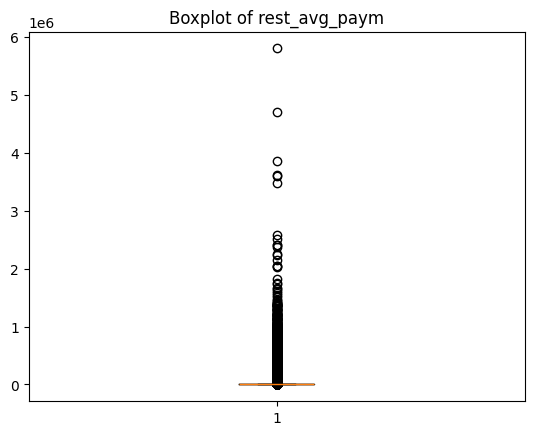

In [37]:
# Boxplot of the column with the most outliers
plt.boxplot(df['rest_avg_paym'])
plt.title('Boxplot of rest_avg_paym')
plt.show()

> The boxplot confirm the previos outliers count. The question here is what is wrong with this values and what to do with them. 

**Potential Causes of Outliers:**

* Errors in Data Entry: Typos or mistakes during data collection or entry could lead to unrealistic values in the account balance.
* Extreme Cases: There might be a small number of clients with exceptionally high or low account balances compared to the majority.
* Data Source Issues: Inconsistency or errors in the way the data was obtained could introduce outliers.
* Inaccurate Feature Definition: The definition of "average salary account balance" itself might be unclear. Does it represent the average salary deposited each month, or the current balance?

In [38]:
df['rest_avg_paym'].describe()

count    3.551900e+05
mean     7.108816e+03
std      4.716785e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.798600e+06
Name: rest_avg_paym, dtype: float64

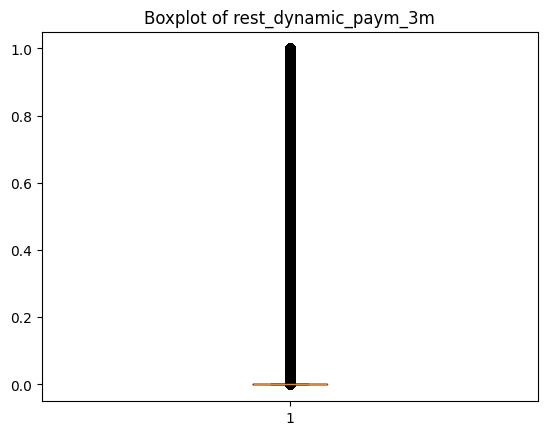

In [39]:
# Boxplot of the column with the most outliers
plt.boxplot(df['rest_dynamic_paym_3m'])
plt.title('Boxplot of rest_dynamic_paym_3m')
plt.show()

In [40]:
df['rest_dynamic_paym_3m'].describe()

count    355190.000000
mean          0.076570
std           0.204059
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: rest_dynamic_paym_3m, dtype: float64